<a href="https://colab.research.google.com/github/SeongwonTak/TIL_swtak/blob/master/210123_Clustering_Kmeans_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#210123 Clustering : Kmeans 2

어제에 이어서 Kmeans에 대해서 알아본다.

오늘 알아보고자 하는 방법은 K 값을 어떻게 고를 것인가?에 대한 문제이다. 물론 시각화 결과상 너무 "자명"한 경우에는 그 값을 고르면 될 것이다. 하지만 그렇지 않는 경우에는 K값을 어떻게 선정할지에 대해 어려움이 따른다.

## 1. 개요

K값을 고른다는 점은, 군집화의 목표, 즉 inertia의 값을 최소화 하는 것을 목표로 할 것이다. 당연히 K값 커지면 커질수록 inertia의 값은 많아질 것이나 과도하게 커진다면 군집화의 의미가 없을것이다.

당연한 것이, 샘플 데이터가 100개인데 군집이 1개거나 100개라면? 아! 의미가 없다.
따라서 적절한 K값을 고르는 것은 중요할 것이다.

- Elbow analysis
- Silhouette analysis

이 두가지 방법에 대해 알아보며 K값을 고르고 군집화의 모델을 평가하는 방법을 알아보고자 한다.

## 2. Elbow analysis

직관적으로 생각하면 K값이 커지면 당연히 SSE가 줄어들기 때문에, 어느 지점에서 효율적일지를 생각해봐야 할 것이다.

즉, **어느 순간부터는 SSE가 감소되는 정도의 효율이 줄어들 것이다**. 바로 그 지점이, 가장 적합한 K값이라고 보면 될 것이다.

In [1]:
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
import math
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# make_blobs를 통한 샘플 데이터 형성.
x, y = make_blobs(n_samples=500, centers=7, n_features=2, random_state=2)
points = pd.DataFrame(x, y).reset_index(drop=True)
points.columns = ["x", "y"]
points.head()

,x,y
0,-1.463359,-8.461621
1,-7.496546,0.497524
2,-7.605576,-0.842749
3,-2.993489,-3.085778
4,-6.883600,1.185068


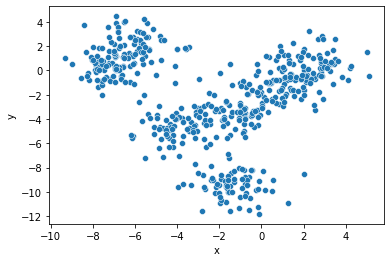

In [3]:
sns.scatterplot(x="x", y="y", data=points)
plt.show()

그림을 보아하니, 3개? 4개? 명백하게 좀 알기가 어렵다. 이러한 경우 적절한 K값의 선택은 매우 중요할 것이다. 이를 위한 엘보우 방법을 알아보고자 한다.
엘보우 방법을 위해서는 일단 Kmeans 모델부터 생성해야 한다.

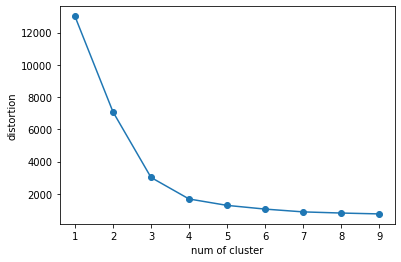

In [4]:
from sklearn.cluster import KMeans

distortions = []
# 지금은 몇개인지 모른다! 따라서 n_cluster를 막 고르면 안된다.
for i in range(1, 10):
  km = KMeans(n_clusters=i,
              init='k-means++',
              n_init=10,
              max_iter=250,
              random_state=0)
  km.fit(x)
  distortions.append(km.inertia_)  # inertia 값을 List에 추가해서 그리자
plt.plot(range(1,10), distortions, marker='o')
plt.xlabel('num of cluster')
plt.ylabel('distortion')
plt.show() 

그림을 통해서 우리는 5 이상은 크게 의미가 없을을 알 수 있고, 2 이하는 너무 의미가 없을을 알 수 있다.
그림을 통해 4 이후부터 지나치게 감소폭이 떨어지는 것을 통해 cluster를 4개로 설정하는 것이 적합함을 알 수 있다. 최종 결과를 확인해보자.

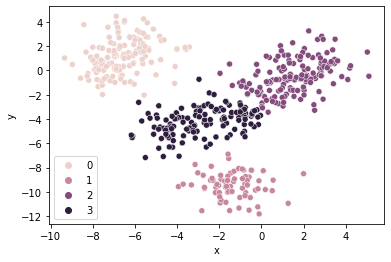

In [19]:
km2 = KMeans(n_clusters=4,
            init='random',
            n_init = 10,
            max_iter = 500,
            tol=1e-04,
            random_state=0)
y_km2 = km2.fit(points)

# 결과 확인
result_by_sklearn = points.copy()
result_by_sklearn["cluster"] = y_km2.labels_

sns.scatterplot(x="x", y="y", hue="cluster", data=result_by_sklearn);
plt.legend()
plt.show()

시각적으로만 봐도 4개를 통해 중간의(?) 큰 부분이 적합하게 나누어져 있음을 알 수 있다.

## 3. Silhouette Analysis

다른 방법 중 하나는 실루엣 분석이다. 이 방법은 K-means 외에는 다른 방법에도 적용 가능한 방법으로, **cluster 내 샘플들이 얼마나 조밀하게 모여 있는지를 측정할 수 있다.**

Silhouette coefficient 계산을 통해 분석할 수 있는데, 우선 어떻게 계산을 해야 할지 알아보자.

- 1단계. cluster cohension 계산

  cluster cohension이란, 샘플과 동일한 군집에 속한 다른 샘플들간의 평균 거리이다. 이를 $a_{i}$로 표기하자.

- 2단계. cluster separation 계산

  cluster separation이란, 샘플과 다른 군집 중 가장 가까은 군집까지의 평균 거리이다. 이를 $b_{i}$로 표기하자.

- 3단계. silhouette coefficient 계산

$$ s_{i} = \frac{b_{i}-a_{i}}{max\{b_{i},a_{i}\}}$$

실루엣 계수는 -1에서 1 사이의 값을 가질 수 있다.
이상적인 실루엣 계수는 당연히, 같은 군집내에서는 가까이 묶여있어야 하고, 인접한 다른 군집과 명백히 분류되어야 하므로, 1에 가까울 것이다.

이를 계산하는 코드는 아직 검토가 필요하여 추후에 올려보고자 한다.